![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [13]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [14]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [6]:
# Celda 1
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [1, 51394.909090909096],
 'n_samples': 7031,
 'gain': 0.23630504821132137,
 'sl': {'y_pred': 1,
  'y_prob': 0.8375781948168007,
  'level': 1,
  'split': [0, 2015.0],
  'n_samples': 4474,
  'gain': 0.03713896892744761,
  'sl': {'y_pred': 1,
   'y_prob': 0.6404416839199448,
   'level': 2,
   'split': [0, 2013.0],
   'n_samples': 1447,
   'gain': 0.043426293133466354,
   'sl': {'y_pred': 0,
    'y_prob': 0.2780487804878049,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 203,
    'gain': 0.05394731382546758,
    'sl': {'y_pred': 0,
     'y_prob': 0.09195402298850575,
     'level': 4,
     'split': [1, 35652.36363636363],
     'n_samples': 85,
     'gain': 0.01352946029496721,
     'sl': {'y_pred': 0,
      'y_prob': 0.24,
      'level': 5,
      'split': [2, 1.0],
      'n_samples': 23,
      'gain': 0.08132745221592097,
      'sl': {'y_pred': 0,
       'y_prob': 0.15,
       'level': 6,
       'split': [1, 329

In [11]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [12]:
prediction = tree_predict(X_test, tree)

In [13]:
iguales = prediction==y_test

accuracy = np.count_nonzero(iguales)/prediction.shape[0]

accuracy

0.8599884526558892

### Mejor Accurancy con libreria (Solo para comprobar)

In [40]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

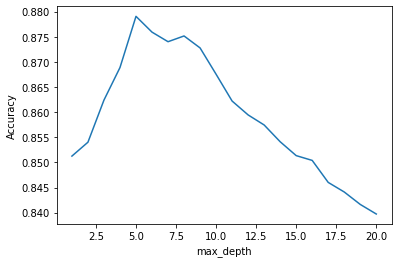

In [42]:
# Gráfica max_depth versus RMSE (error del modelo)
import matplotlib.pyplot as plt

plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [47]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8790856598120659, 5)

In [48]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=5, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [52]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':data, 'importance':clf.feature_importances_}).sort_values('importance')

ValueError: Data must be 1-dimensional

In [53]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.879086
std       0.011336
min       0.860000
25%       0.871783
50%       0.877143
75%       0.888969
max       0.895138
dtype: float64

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [14]:
# Celda 2
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [39]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = data.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 3824, 2046, 2560]),
 array([1999, 4774,  173, ..., 5803,  742, 5039]),
 array([2114, 4003, 3565, ..., 2965,  679, 2539]),
 array([ 6265,  2062,  9901, ...,  8182,  8981, 10457]),
 array([ 1727,  9002, 10082, ...,  9627,  6818,  2533]),
 array([ 9342,  8135,  1731, ..., 10225,  1367,  9054]),
 array([10297,  4474,  4234, ..., 10043,  4228,  5067]),
 array([9836, 9902, 5024, ..., 1281, 3089, 3668]),
 array([ 4266,  6769, 10150, ...,  7107,  7829,  8145]),
 array([6838,   84, 6064, ..., 5539,  847, 9812])]

In [37]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeClassifier de sklearn
treeclf = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = data.iloc[sample, 1:]
    y_train = data.iloc[sample, 0]
    treeclf.fit(X_train, y_train)
    y_pred.iloc[:,i] = treeclf.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014
326011,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014
242354,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014
266376,2017,2017,2017,2017,2016,2017,2017,2017,2016,2017
396954,2017,2017,2017,2017,2016,2017,2017,2017,2016,2017
...,...,...,...,...,...,...,...,...,...,...
144298,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014
364521,2017,2017,2017,2017,2016,2017,2017,2017,2016,2017
120072,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014
99878,2017,2017,2017,2014,2016,2017,2017,2014,2016,2014


In [31]:
# Desempeño de cada árbol
from sklearn.metrics import mean_squared_error
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2016.365568456821
Árbol  1 tiene un error:  2016.377964029108
Árbol  2 tiene un error:  2016.377964029108
Árbol  3 tiene un error:  2013.4821001033235
Árbol  4 tiene un error:  2015.4908534858173
Árbol  5 tiene un error:  2016.377964029108
Árbol  6 tiene un error:  2016.427607117587
Árbol  7 tiene un error:  2013.7488024375598
Árbol  8 tiene un error:  2015.4400331283139
Árbol  9 tiene un error:  2013.5318145885547


In [32]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    2015.9
326011    2015.9
242354    2015.9
266376    2016.8
396954    2016.8
           ...  
144298    2015.9
364521    2016.8
120072    2015.9
99878     2015.9
387162    2016.8
Length: 3464, dtype: float64

In [33]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

2015.3619433174208

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [27]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clfBagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=10, max_features= int(np.log(X_train.shape[1])), bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clfBagging.fit(X_train, y_train)

predicted_clfBag = clfBagging.predict(X_test)

accuraccy_bagging = metrics.accuracy_score(y_test, predicted_clfBag)
accuraccy_bagging

0.0

In [28]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
clfBagging.fit(X_train, y_train)
y_pred = clfBagging.predict(X_test)
y_pred

array([2017, 2017, 2017, ..., 2017, 2017, 2017], dtype=int64)

In [29]:
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred))

2016.377964029108

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [22]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier

# Selección de variables predictoras
feature_cols = data.columns.drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [23]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [24]:
#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
from sklearn.model_selection import cross_val_score
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.837348
std       0.011587
min       0.815062
25%       0.832499
50%       0.835636
75%       0.846630
max       0.852381
dtype: float64

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

### Calibración de n_estimators ó (cantidad de arboles) - n_estimators es la cantidad de árboles a contruir dentro del bosque aleatorio

In [10]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 50, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

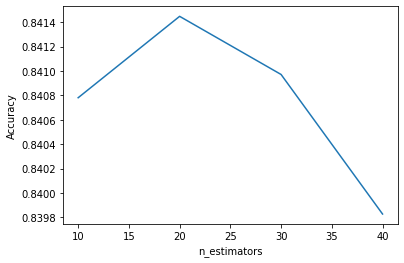

In [12]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

### Calibración max_features (max_features es el número de variables que se deben considerar en cada árbol)

In [34]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)
feature_range

range(1, 10)

In [35]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

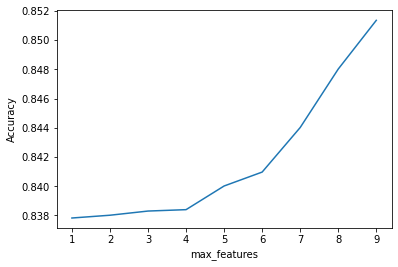

In [36]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [37]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
clf = RandomForestClassifier(n_estimators=200, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(max_features=9, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [38]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000038
3,M_Camry4dr,0.001206
5,M_CamryL,0.004829
7,M_CamrySE,0.006464
2,M_Camry,0.007980
8,M_CamryXLE,0.008237
6,M_CamryLE,0.016366
0,Year,0.156057
1,Mileage,0.798823


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [41]:
!pip install xgboost

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\lacc8\\anaconda3\\envs\\miad\\lib\\site-packages\\numpy-1.22.2.dist-info\\METADATA'



In [42]:
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [44]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
from sklearn import metrics

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

[01:20:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.9047160731472569, 0.8856812933025404)

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [7]:
# Celda 7
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier

clf2 = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, gamma = 0.25)
clf2

XGBClassifier(alpha=10, base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.25, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [15]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
from sklearn import metrics

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

[02:10:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8780049427095036, 0.8432448036951501)

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
